In [1]:
import os, re
import numpy as np

In [2]:
# change to the root folder
base_dir = "/Users/jibanmac/Documents/GitHub/gpy_dla_detection/"
os.chdir(base_dir)

try:
    assert "null_gp.py" in os.listdir("gpy_dla_detection")
except Exception as e:
    print(e)
    print("[Warning] Change the directory of base_dir to the path of your gpy_dla_detection repository.")

In [3]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

# Tutorial: Automate Lyman alpha absorption detection 

In this tutorial, we will demonstrate how to use the Gaussian process code to detect Lyman alpha absorbers in the quasar spectra.

There are a few steps to understand how to use the GP code on quasar spectra, which we will go through step-by-step:
1. Understand Quasar Spectrum Data
2. Understand Voigt Profile
3. Understand how to use Bayesian model selection

## Understand Quasar Spectrum Data

A spectrum describes the number of photons (or the amount of light) we received from the astronomical object (in this case, quasar) at each wavelength.
Below we will download a spectrum from SDSS website, and use Python to plot the spectrum.

In [4]:
# The test selection file includes a list of 100 quasar spectra and their redshifts
from tests import test_selection
# The read spec module helps us to download and read the spectrum (for SDSS DR12 spectrum)
from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec

In [5]:
# take a spectrum and download it
nspec = 51
filename = test_selection.filenames[nspec]
z_qso    = test_selection.z_qsos[nspec]

# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    # This line gets the plate, mjd, and fiber_id from the given filename
    # Note: re is the regex.
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits", filename,
    )[0]
    # Download the file using the given plate, mjd, and fiber_id
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

# make sure the file exists
assert os.path.exists(filename) == True

In [6]:
# Read the raw spectrum: This line reads the spectrum file into four numpy arrays
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

* `wavelengths`: 1D float array. The observer-frame wavelengths of the quasar spectrum
* `flux`: 1D float array. The flux (photos per wavelength bin) of the quasar spectrum
* `noise_variance`: 1D float array. The instrumental noise variance of the flux.
* `pixel_mask`: 1D boolean array. The mask given by SDSS, which should be used to mask out undesired region of the spectrum.

Text(0, 0.5, 'Flux')

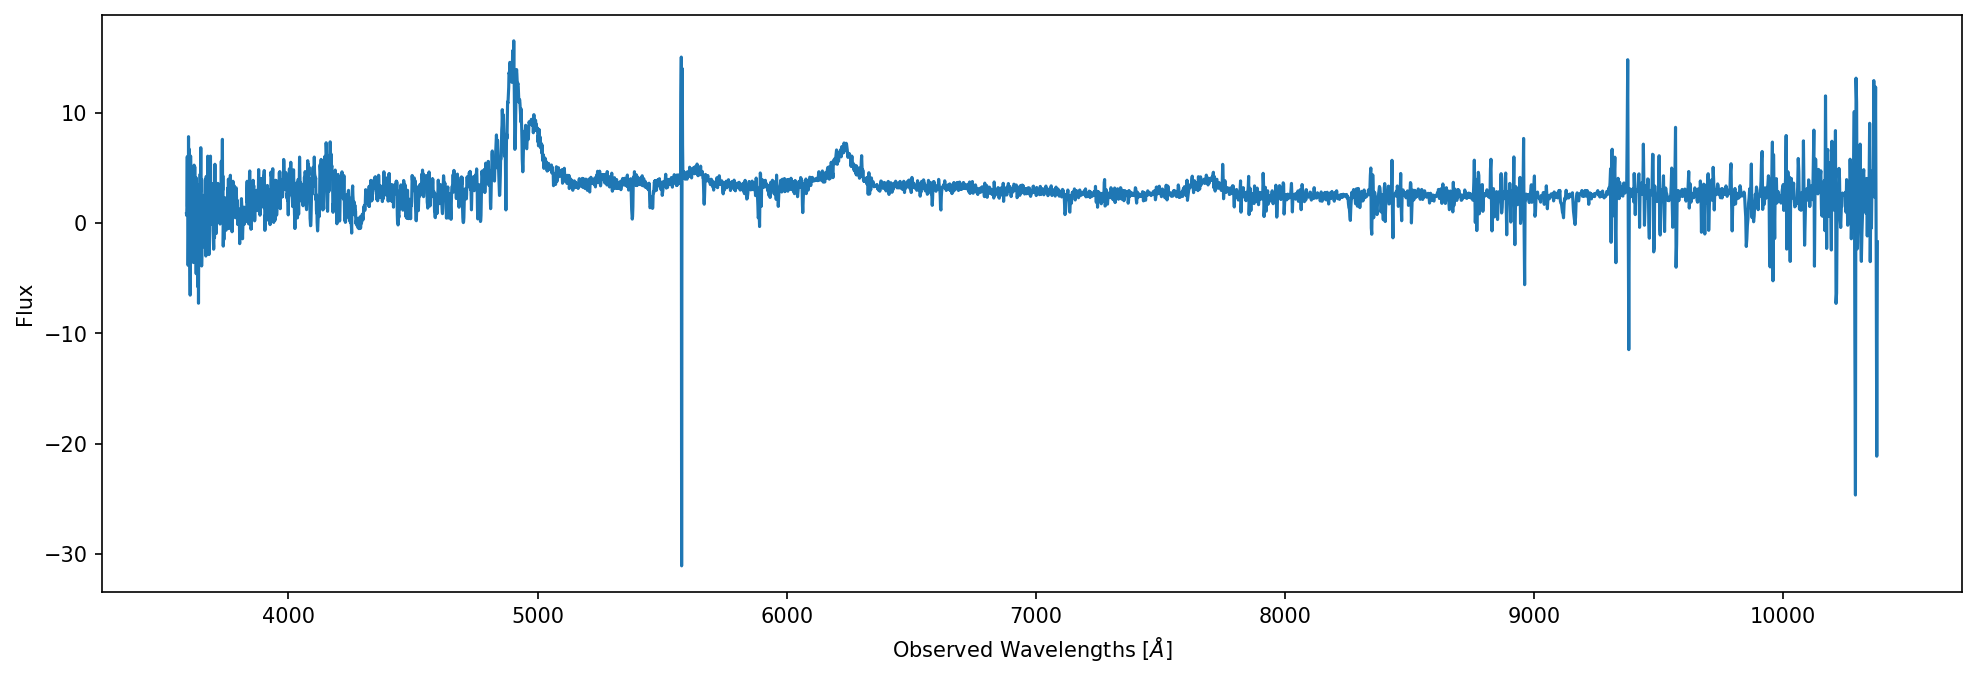

In [7]:
# plot it in "observed wavelengths"
plt.figure(figsize=(16, 5))
plt.plot(wavelengths, flux)
plt.xlabel("Observed Wavelengths [$\AA$]")
plt.ylabel("Flux")

Note that the **observed wavelengths** are redshifted, meaning they are stretched by the expansion of the Universe. The conversion of the observed wavelengths to the original wavelengths before redshifts is:

$$
\lambda_\mathrm{obs} = \lambda_\mathrm{rest} \times \frac{1}{a}
$$

$a$ is a number describes the size of the Universe, with a values $0 < a \leq 1$. At the current time, we have $a = 1$, so the observed wavelengths are the same as the original wavelegnths. We annotated the original wavelengths are $\lambda_\mathrm{rest}$, meaning the **rest wavelengths** or the wavelengths in the rest-frame.

$a$ is equal to $1/(1 + z)$, where $z$ is the redshift.

$$
\lambda_\mathrm{obs} = \lambda_\mathrm{rest} \times (1 + z)
$$

Below, we shift the observed wavelengths to rest-frame wavelengths, which is the wavelengths we see in the lab on the earth (no redshifted). It's a standard procedure for a quasar spectrum analysis to shift the observed wavelengths to rest-frame.

Text(0, 0.5, 'Flux')

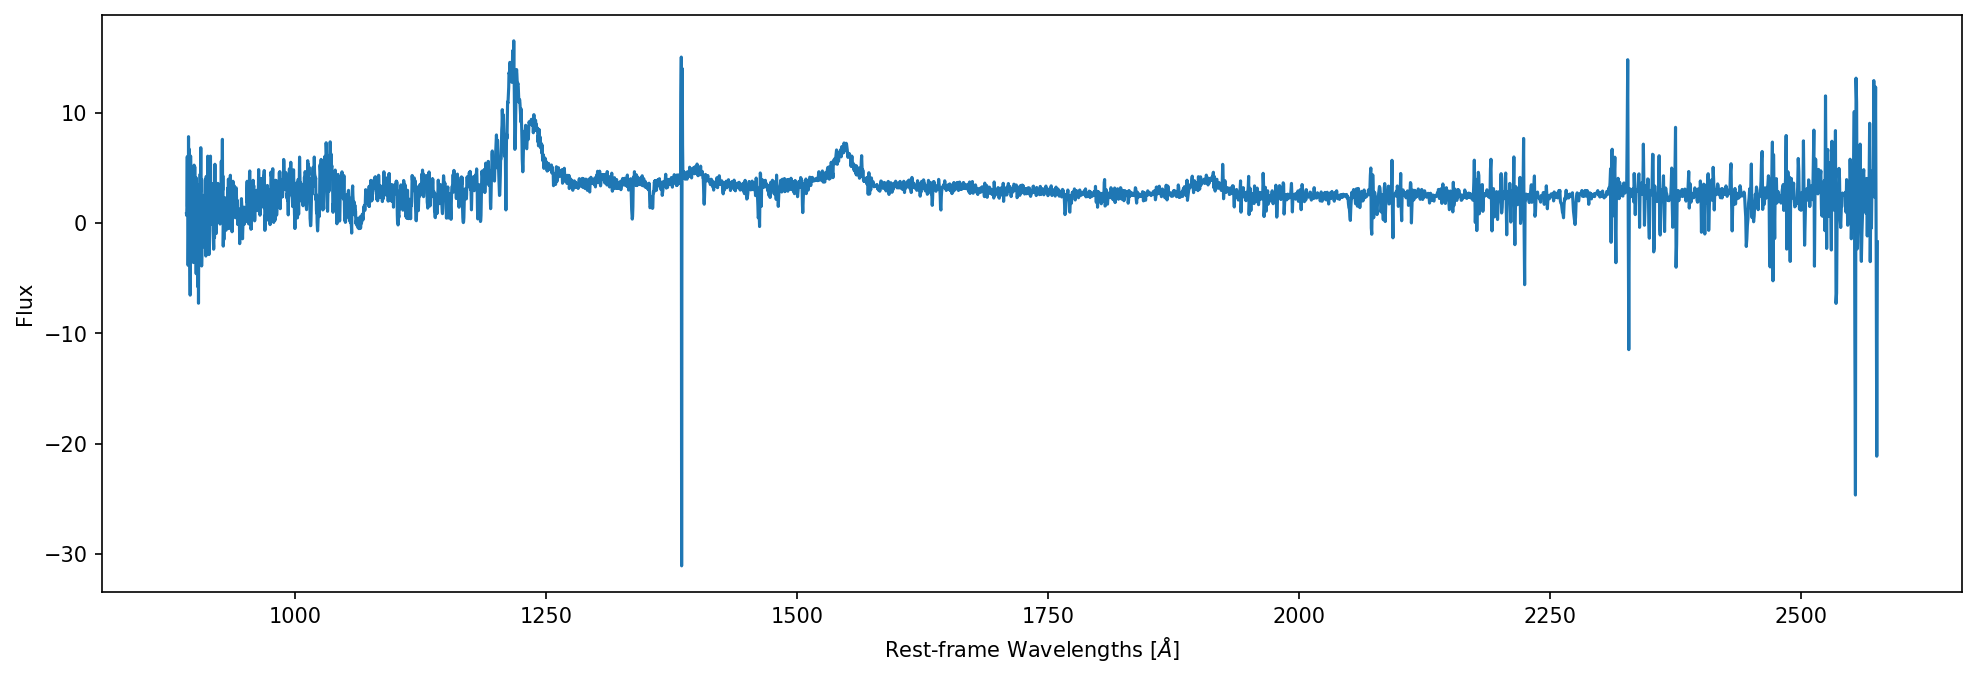

In [8]:
# plot it in "observed wavelengths"
rest_wavelengths = wavelengths / (1 + z_qso)

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, flux)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Flux")

Note that the x-axis is changed from observed wavelengths (the wavelengths of quasar photons stretched by the expansion of the Universe) to the rest-frame wavelengths (the wavelengths we see if there's no expansion, i.e., the photos that a person at the rest-frame of the quasar would see.)

The blue line is a real quasar observation from Sloan Digital Sky Survey.
Why the line looks like there are lots of wiggles is because there is an uncertainty associated with each flux pixel in the spectrum.
The uncertainty is due to many reasons- exposure time is not enough, instrumental limitations, unknown sources.

We know there are several emission lines are usually in quasar spectrum. For example, 

| Rest-Wavelength | Emission Line |
| --- | --- |
| 1215.24 | $Ly\alpha$ (Lyman Alpha) |
| 1549.48 | CIV (Carbon Four)  |
| 2799.117 | MgII (Magnesium Two) |

See the detailed table in [here](https://classic.sdss.org/dr6/algorithms/linestable.html).

Let's label those lines in the spectrum:


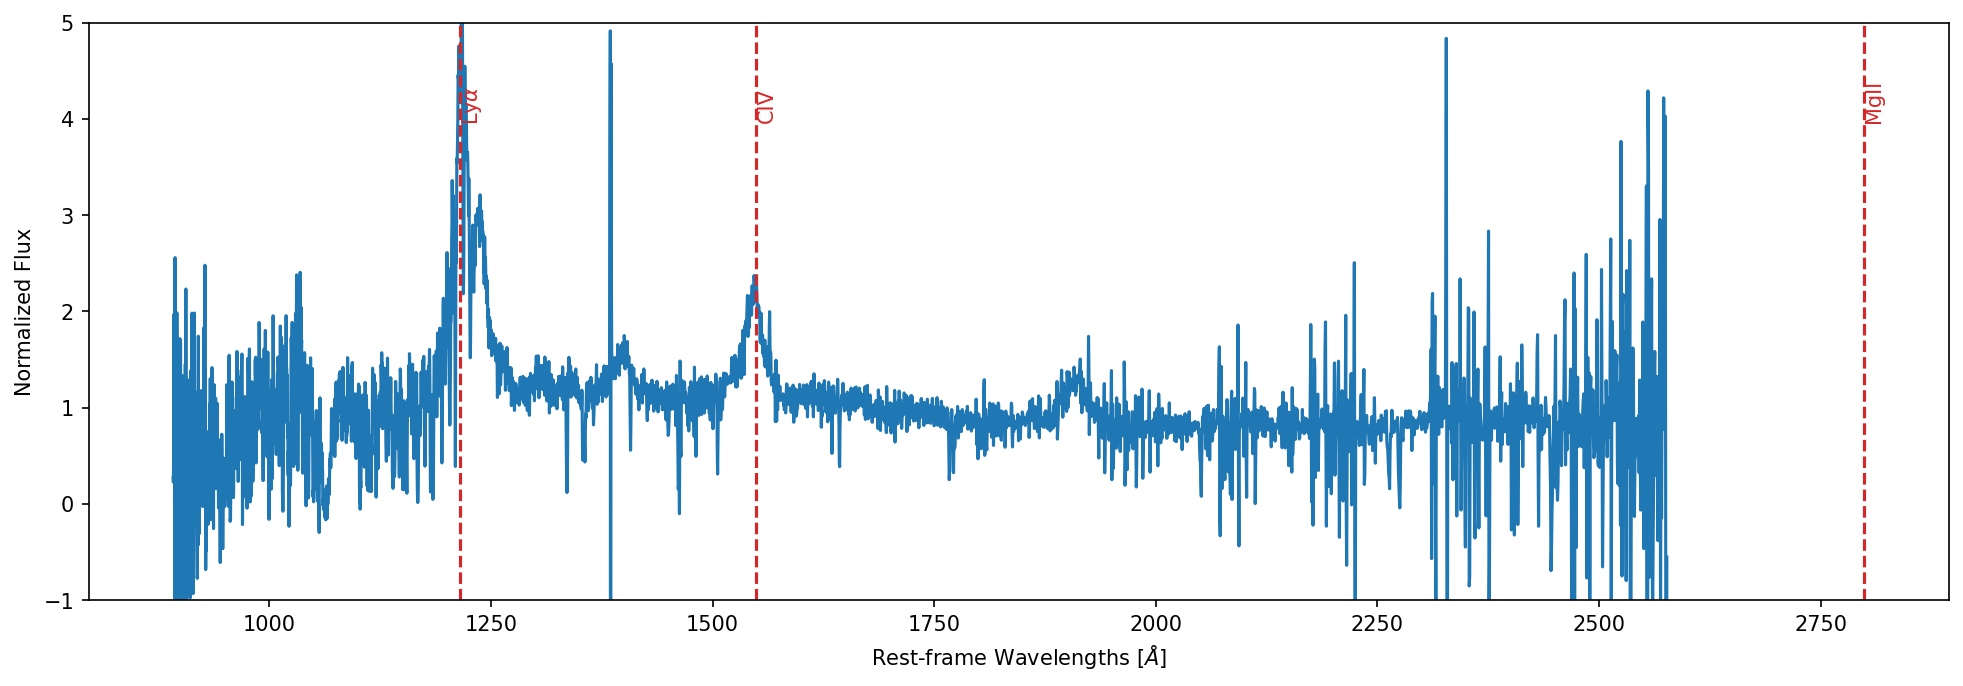

In [55]:
# Names and Rest-Wavelengths of the Emission Lines
emission_rest_wavelengths = [1215.24, 1549.48, 2799.117]
emission_names = [r"Ly$\alpha$", r"CIV", r"MgII"]

plt.figure(figsize=(16, 5))
# I did a normalization in this step to make the plot esier to see
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1, 5)

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, color="C3", ls="--")
    plt.text(w, 4, n, rotation="vertical", color="C3")


For Lyman alpha absorptions, these absorptions will be in the rest-frame wavelengths $< 1216 \AA$:

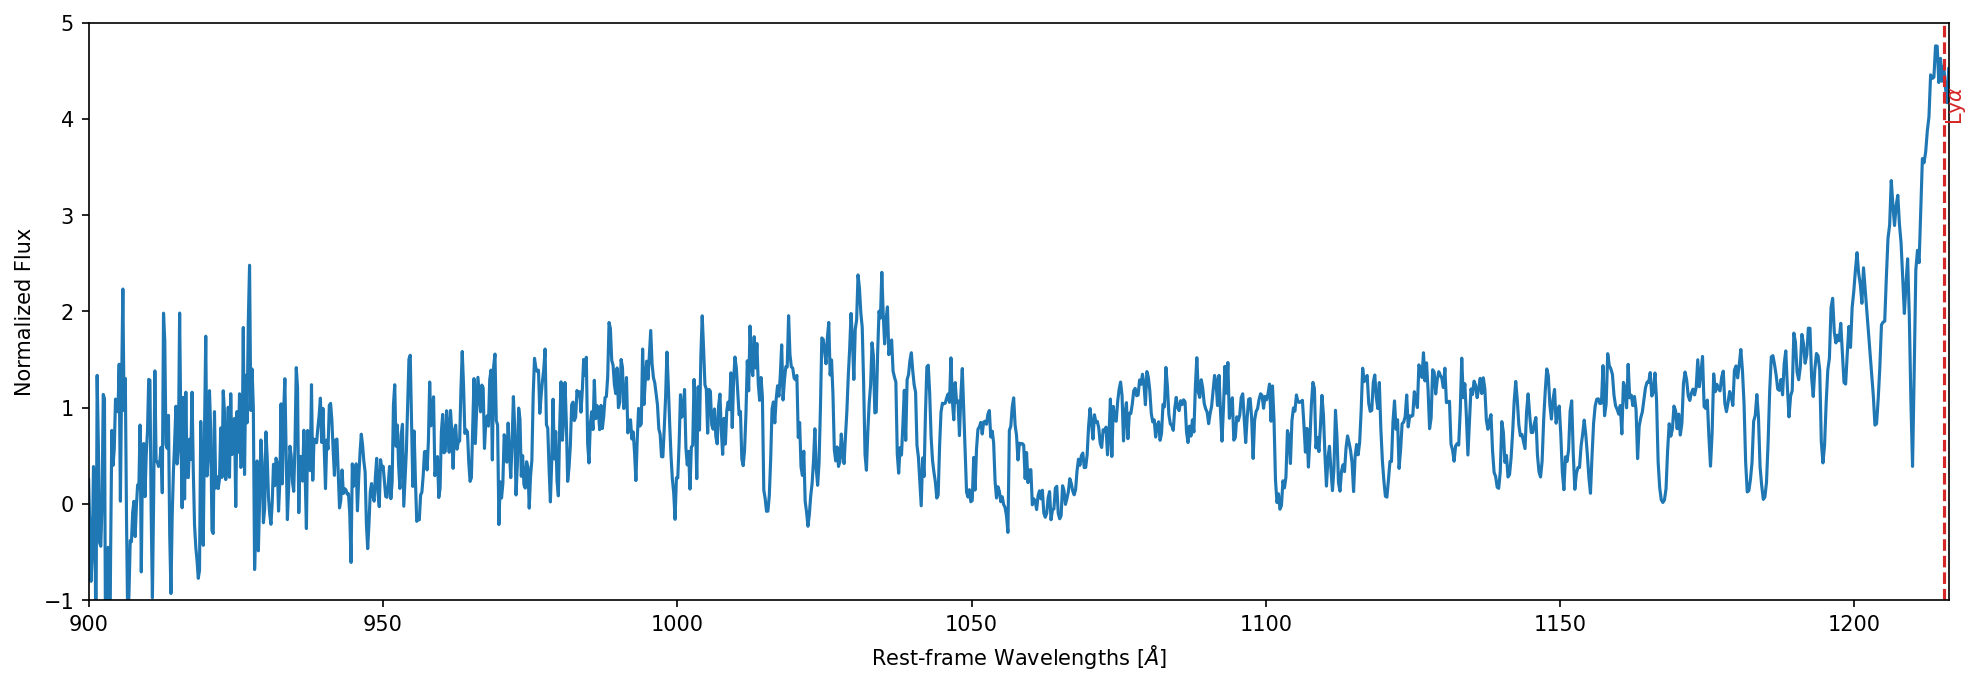

In [9]:
# Names and Rest-Wavelengths of the Emission Lines
emission_rest_wavelengths = [1215.24]
emission_names = [r"Ly$\alpha$"]

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, flux / np.mean(flux))
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-1 ,5)
plt.xlim(900, 1216)

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, color="C3", ls="--")
    plt.text(w, 4, n, rotation="vertical", color="C3")


## Understand Voigt Profile

Voigt profile is a standard profile used by astronomers to model the absorption systems:
$$
\begin{equation}
   \begin{split}
      \phi(v, b, \gamma)
      &=\\
      \int \frac{d v}{\sqrt{2\pi}\sigma_v} &\exp{(-v^2 / 2\sigma_v^2)}
      \frac{4 \gamma_{\ell u}}{16 \pi^2 [ \nu - (1 - v/c)\nu_{\ell u} ]^2 + \gamma_{\ell u}^2},
   \end{split}
\end{equation}
$$
which is a convolution between a Lorenztian line profile and a Gaussian line profile.
The $\sigma_v$ is the one-dimensional velocity dispersion, $\gamma_{\ell u}$ is a parameter for Lorenztian profile, $\nu$ is the frequency, and $u$ represents the upper energy level and $\ell$ represents the lower energy level.

Both profiles are parameterised by the relative velocity $v$, which means both profiles are distributions in the 1-dimensional velocity space:
$$
\begin{equation}
   v = c \left( \frac{\lambda}{\lambda_{1u}} \frac{1}{(1 + z_\mathrm{absorber})} -1 \right).
\end{equation}
$$
The standard deviation of the Gaussian line profile is related to the broadening parameter $b = \sqrt{2} \sigma_v$, and if we assume the broadening is entirely due to thermal motion:
$$
\begin{equation}
   b = \sqrt{ \frac{2 k T}{m_p} }.
\end{equation}
$$
Introducing the damping constant $\Gamma  = 6.265 \times 10^8 \textrm{s}^{-1}$ for Lyman alpha, we have the parameter $\gamma_{\ell u}$ to describe the width of the Lorenztian profile
$$
\begin{equation}
   \gamma_{\ell u} = \frac{\Gamma \lambda_{\ell u}}{4\pi}.
\end{equation}
$$

We will use the `voigt.py`, which is a Voigt profile we've written for Lyman alpha absorptions, to demonstrate the voigt profile.

In [10]:
from gpy_dla_detection import voigt

* `wavelengths` (np.ndarray) : observed wavelengths (Å)
* `nhi` (float) : column density of this absorber   (cm⁻²)
* `z_dla` (float) : the redshift of this absorber   (dimensionless)
* `num_lines` (int) : the number of Lyman series lines used in this absorber. Maximum 31.
* `broadening` (boolean) : whether apply Gaussian broadening to the observed spectrum.


(900.0, 1216.0)

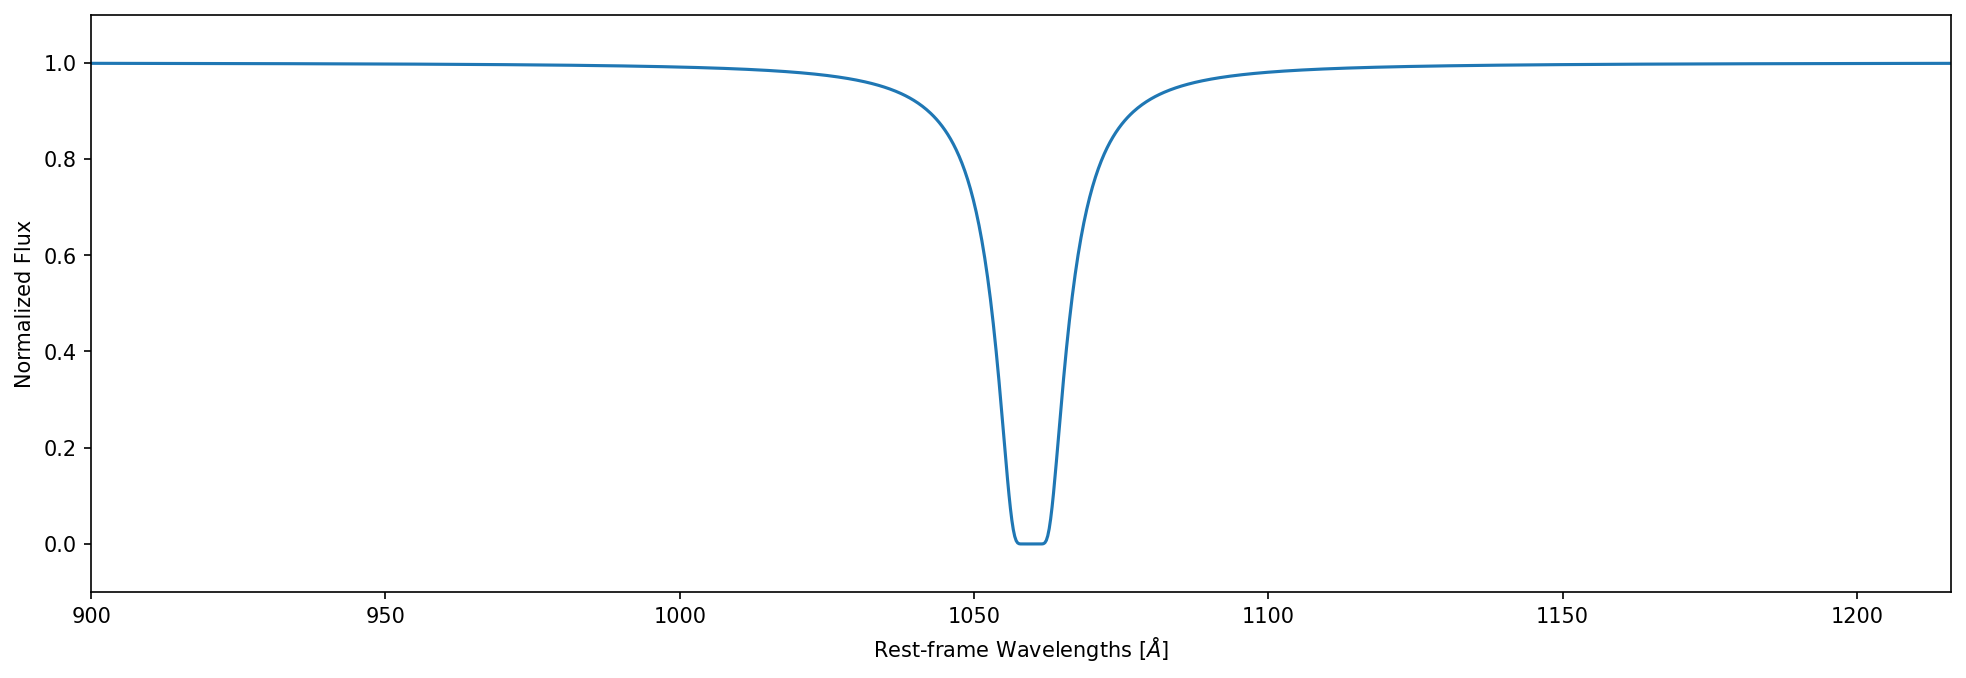

In [11]:
# Assume there's an absorber at redshift 2.511
z_dla = 2.511
nhi   = 10**21 # [cm^-2]

voigt_profile = voigt.voigt_absorption(
    wavelengths,
    nhi=nhi,
    z_dla=z_dla,
    num_lines=1,
    broadening=False,
)

plt.figure(figsize=(16, 5))
plt.plot(rest_wavelengths, voigt_profile)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-0.1 , 1.1)
plt.xlim(900, 1216)

This profile is saturated because part of it reach flux=0, which means the photons are completely absorbed by the neural hydrogen.

The center part of the profile looks like a Gaussian distribution, while the outskirts are Lorentzian wings.
When the column density (`nhi`) is small, the profile would look more like a Gaussian.

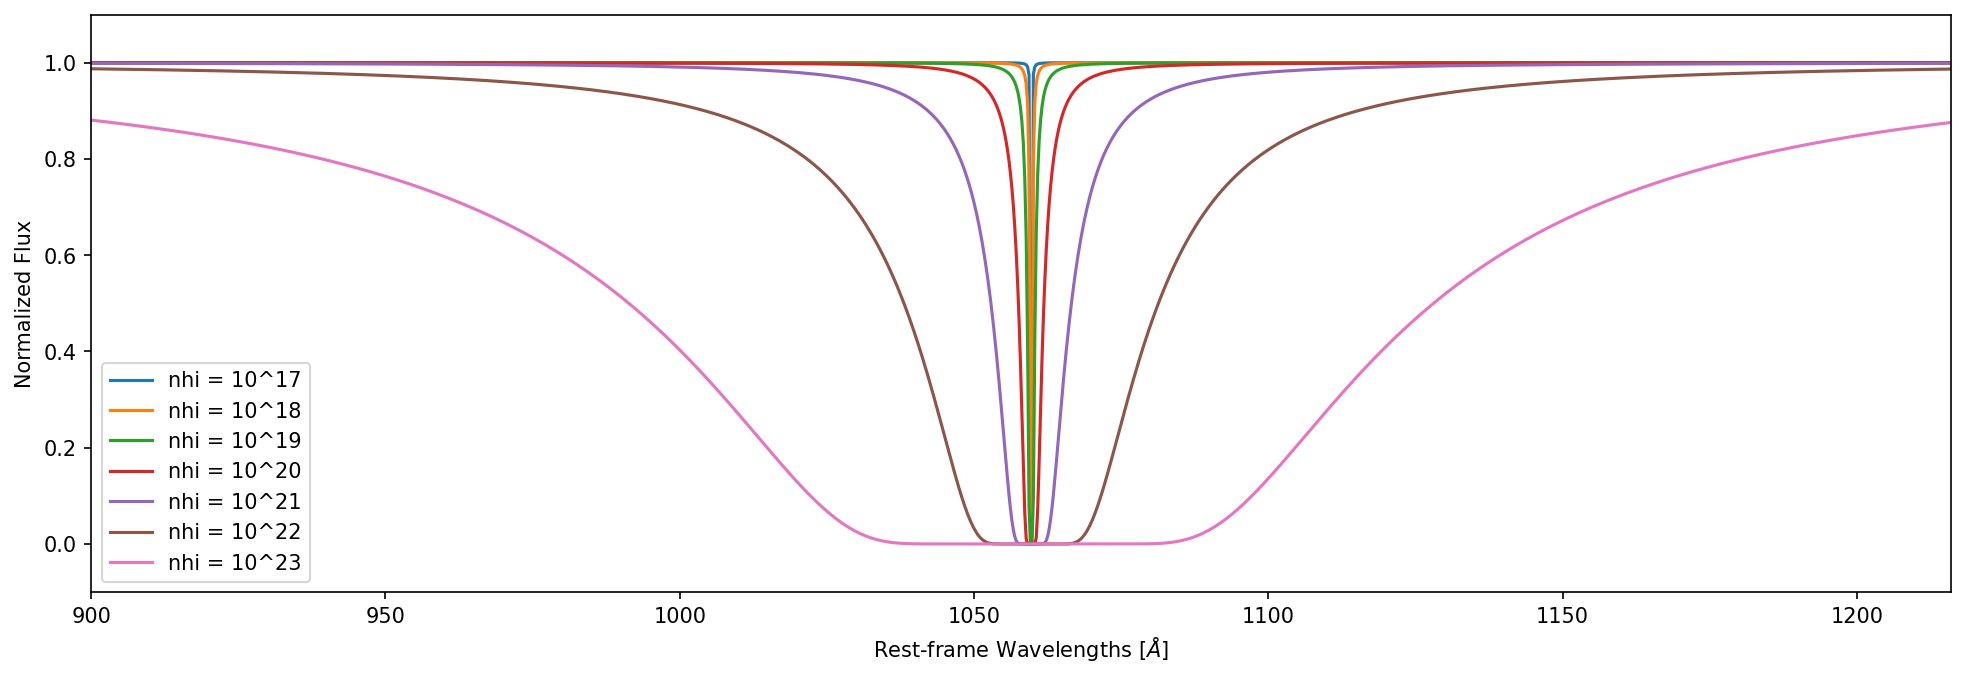

In [12]:
# Assume there's an absorber at redshift 2.511
z_dla = 2.511

list_nhis = [17, 18, 19, 20, 21, 22, 23] # [cm^-2]

plt.figure(figsize=(16, 5))

for nhi in list_nhis:
    voigt_profile = voigt.voigt_absorption(
        wavelengths,
        nhi=10**nhi,
        z_dla=z_dla,
        num_lines=1,
        broadening=False,
    )

    plt.plot(
        rest_wavelengths, voigt_profile,
        label="nhi = 10^{}".format(nhi),
    )

plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-0.1 , 1.1)
plt.xlim(900, 1216)
plt.legend()

Lyman alpha line is a transition from the ground state to the first excited state.
We can include Lyman beta (ground state to second excited state), gamma (ground state to 3rd excited state) just by include the number of `num_lines`.

(850.0, 1216.0)

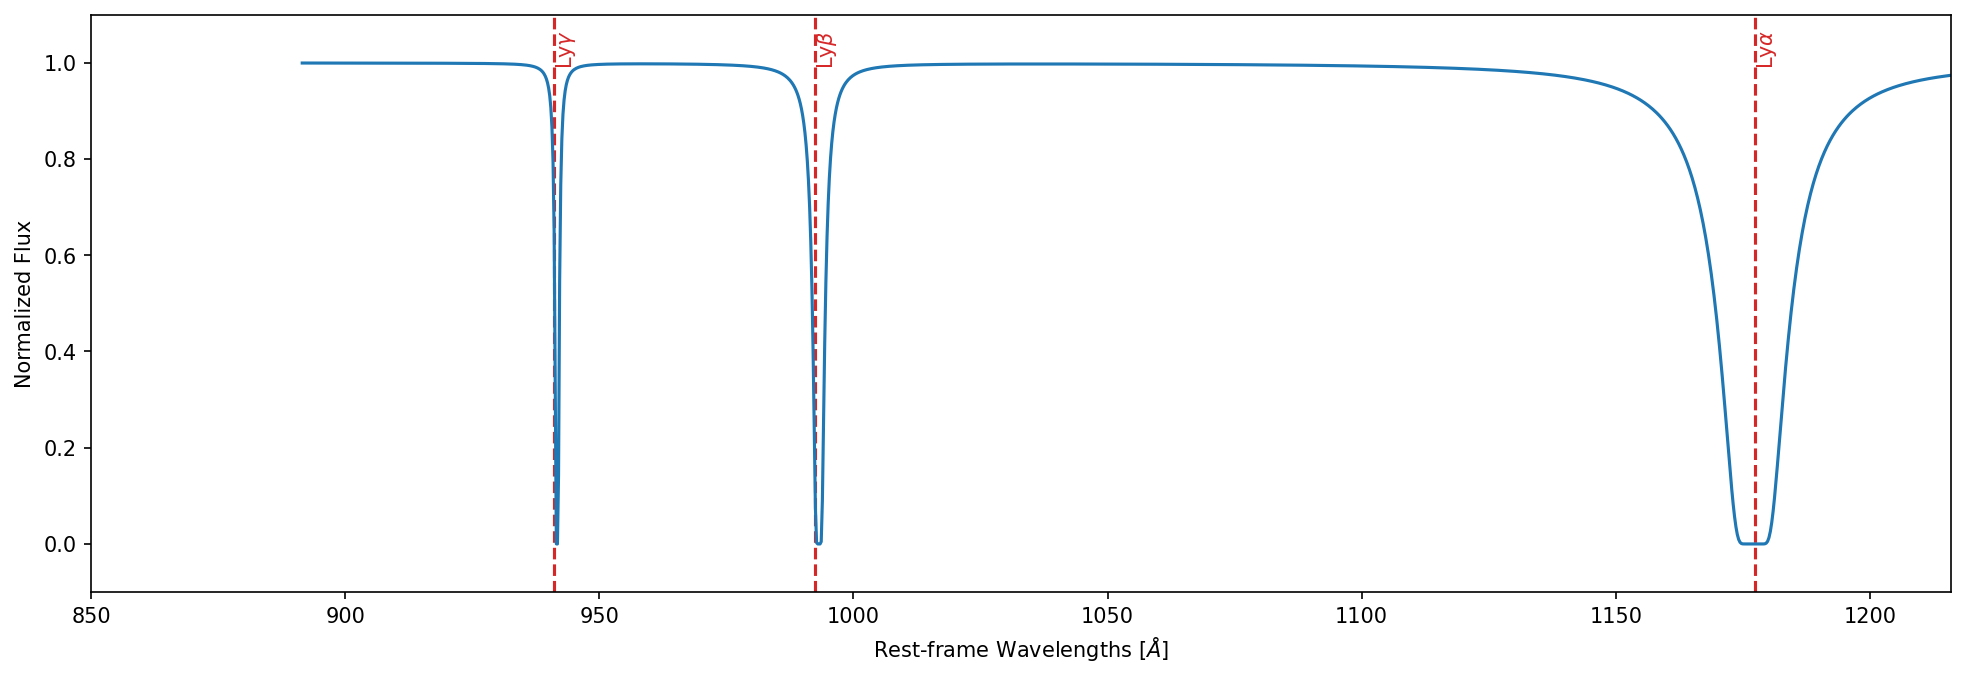

In [13]:
# Assume there's an absorber at redshift 2.9
z_dla = 2.9
nhi   = 10**21 # [cm^-2]

plt.figure(figsize=(16, 5))

voigt_profile = voigt.voigt_absorption(
    wavelengths,
    nhi=nhi,
    z_dla=z_dla,
    num_lines=3,
    broadening=False,
)

plt.vlines(1216 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\alpha$")
plt.vlines(1025 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\beta$")
plt.vlines(972 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\gamma$")
plt.text(1216 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\alpha$", rotation="vertical", color="C3")
plt.text(1025 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\beta$", rotation="vertical", color="C3")
plt.text(972 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\gamma$", rotation="vertical", color="C3")

plt.plot(rest_wavelengths, voigt_profile)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-0.1 , 1.1)
plt.xlim(850, 1216)


If we have 31 Lyman series lines and we lower down the column density to $10^{18}$ [cm^-2]:

(850.0, 1216.0)

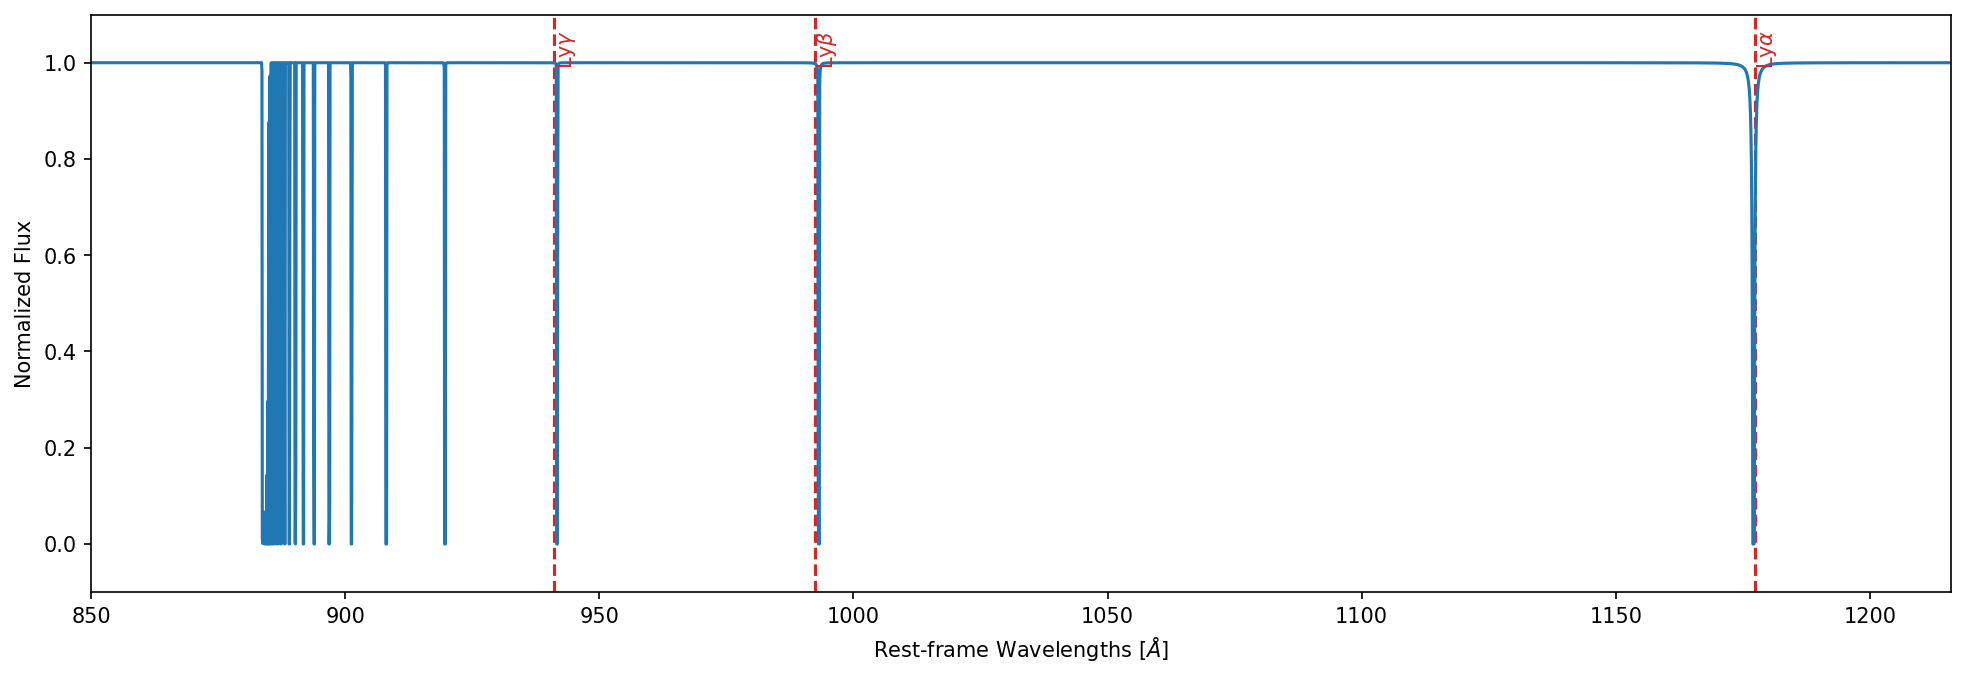

In [108]:
# Assume there's an absorber at redshift 2.9
z_dla = 2.9
nhi   = 10**18 # [cm^-2]

plt.figure(figsize=(16, 5))

voigt_profile = voigt.voigt_absorption(
    np.linspace(850, 1216, num=5000) * (1 + z_qso),
    nhi=nhi,
    z_dla=z_dla,
    num_lines=31,
    broadening=False,
)

plt.vlines(1216 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\alpha$")
plt.vlines(1025 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\beta$")
plt.vlines(972 * (1 + z_dla) / (1 + z_qso), -0.1, 1.1, color="C3", ls="--", label=r"Ly$\gamma$")
plt.text(1216 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\alpha$", rotation="vertical", color="C3")
plt.text(1025 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\beta$", rotation="vertical", color="C3")
plt.text(972 * (1 + z_dla) / (1 + z_qso), 1, r"Ly$\gamma$", rotation="vertical", color="C3")

plt.plot(np.linspace(850, 1216, num=5000), voigt_profile)
plt.xlabel("Rest-frame Wavelengths [$\AA$]")
plt.ylabel("Normalized Flux")
plt.ylim(-0.1 , 1.1)
plt.xlim(850, 1216)


All of these lines will be the feature we can use to constrain Lyman alpha absorbers.

## Understand how to use Bayesian model selection

Bayesian model selection provides a way to compare the performance of different models in a Bayesian way.
For a good lecture, mathmaticalmonk provides a nice [video](https://youtu.be/1CFof6hU3cI).
In a nutshell, you can think Bayesian model selection as a Bayesian way to do hypothesis testing.

Suppose you have two hypothesis: $M_1$ and $M_2$.
Each model has some capability to explain the data, $\mathcal{D}$.
The probability that $M_1$ can explain the data is $p(\mathcal{D} \mid M_1)$, and vice versa.
This probability, the ability of hypothesis explaining a given data, is also called "likelihood".

However, likelihoods are not the whole story.
We need to consider the fact that the $M_1$ and $M_2$ have different occurrence rates, i.e., one of the hypothesis might be rarer happened than the other one.
For example, the number of people who have cancers is less than people who don't, so the hypothsis of a person having a cancer should be assigned a smaller probability.
When you don't consider the base rate, you might misinterpret the results.
This is often called the [base-rate fallacy](https://en.wikipedia.org/wiki/Base_rate).

In some science domains, people say that you need a p-value smaller than $0.05$ to claim the null hypothesis is rejected.
This reflects the fact to take into account the effects of base-rate fallacy.
However, of course, as a Bayesian, we would prefer to express the problem in a Bayesian rate.

We can take into account the base rate by incorporating the prior probabilities, which are the probabilies of the hypotheses, $p(M)$.
You can also think a prior probability is the occurrence of the hypothesis or how common of the hypothesis.

With prior probabilities, we can calculate the posterior probability of the hypothesis, which is how likely this hypothesis is true:
$$
p(M_1 \mid \mathcal{D}) = \frac{p(M_1) p(\mathcal{D} \mid M_1)}{ p(M_1) p(\mathcal{D} \mid M_1) + p(M_2) p(\mathcal{D} \mid M_2) }
$$

Suppose $M_1$ is the null hypothesis with a prior probability $p(M_1) = 0.95$, which means it happen more often than the other hypothesis.
The likelihood of $M_2$ needs to be $p(\mathcal{D} \mid M_2) > 0.95$ to make the hypothesis $M_2$ more likely than $M_1$.
(Reminder: you need to do so quick maths to calculate the posterior probability of $M_2$. Note that $p(M_2) = 1 - p(M_1) = 0.05$)
This also means the likelihood of $M_1$ is less than $0.05$, which is (almost) equivalent to saying p-value (p-value is likelihood in Bayesian's sense) is less than $0.05$.

In the following tutorial, we will use Bayesian model selection to find spectra with Lyman alpha absorbers.
Models and hypotheses are interchangeable in the following text.



We first load the default parameters we had before in the model:

In [14]:
from gpy_dla_detection.set_parameters import Parameters


In [17]:
param = Parameters()

param

{'loading_min_lambda': 910.0, 'loading_max_lambda': 1217.0, 'z_qso_cut': 2.15, 'min_num_pixels': 200, 'normalization_min_lambda': 1310.0, 'normalization_max_lambda': 1325.0, 'min_lambda': 911.75, 'max_lambda': 1215.75, 'dlambda': 0.25, 'k': 20, 'max_noise_variance': 9.0, 'initial_c_0': 0.1, 'initial_tau_0': 0.0023, 'initial_beta': 3.65, 'minFunc_options': {'MaxIter': 2000, 'MaxFunEvals': 4000}, 'num_dla_samples': 10000, 'alpha': 0.97, 'uniform_min_log_nhi': 20.0, 'uniform_max_log_nhi': 23.0, 'fit_min_log_nhi': 20.0, 'fit_max_log_nhi': 22.0, 'prior_z_qso_increase': 0.10006922855944561, 'width': 3, 'pixel_spacing': 0.0001, 'num_lines': 3, 'max_z_cut': 0.010006922855944561, 'min_z_cut': 0.010006922855944561, 'num_forest_lines': 31}

These parameters are the parameters we had when we trained the Gaussian process model. Details can be found in `set_parameter.m`.

We also need the prior probabilities of the models:

In [18]:
from gpy_dla_detection.model_priors import PriorCatalog

# Note: you need to follow the README to download these files! 
prior = PriorCatalog(
    param,
    "data/dr12q/processed/catalog.mat",
    "data/dla_catalogs/dr9q_concordance/processed/los_catalog",
    "data/dla_catalogs/dr9q_concordance/processed/dla_catalog",
)


Text(0, 0.5, 'p(DLA | zQSO)')

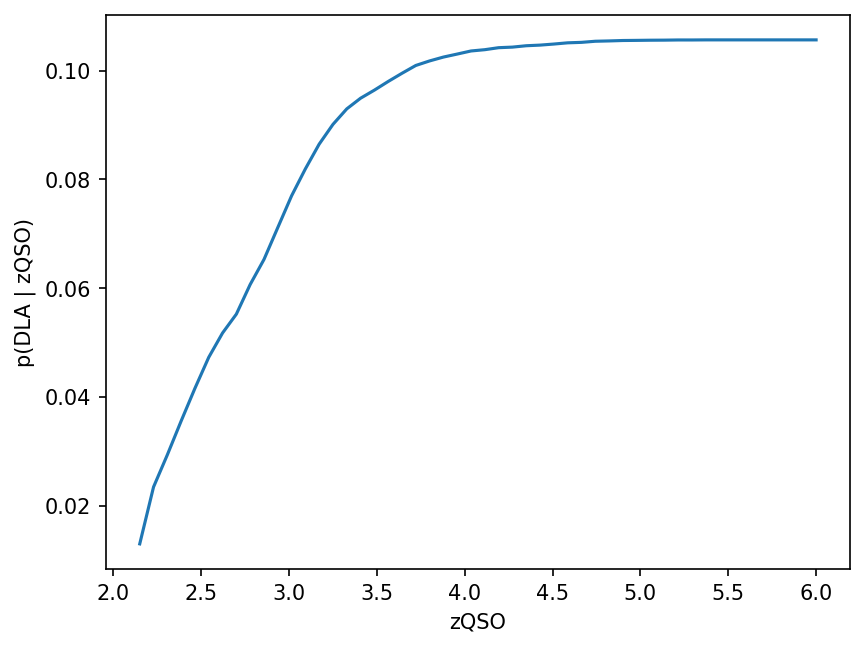

In [20]:
z_qso_list = np.linspace(2.15, 6)

dla_prior = []
for _z in z_qso_list:
    this_num_dlas, this_num_quasars = prior.less_ind(_z)

    # The prior of DLA = number of DLAs at a given redshift / (number of quasar sightlines with and without DLAs)
    _dla_prior = this_num_dlas / this_num_quasars
    dla_prior.append(_dla_prior)

plt.plot(z_qso_list, dla_prior, label="p(DLA | zQSO)")
plt.xlabel("zQSO")

plt.ylabel("p(DLA | zQSO)")

The above shows how likely you can find a DLA in a quasar spectrum at a given redshift, and it's more likely (~10 percent) to find a DLA at higher redshift (zQSO > 4).

Our prior is from visual inspection of damped Lyman alpha absorbers in SDSS DR9.
Since we are considering a more general Lyman alpha absorbers between $\log N_\mathrm{HI} = 17 - 23$, the prior might be underestimated.
We will discuss about how to change the prior later.

Let's first define our null model and absorption model (the model with a Lyman alpha absorber) first.

In [21]:
from gpy_dla_detection.null_gp import NullGP
from gpy_dla_detection.dla_gp import DLAGP

TODO :   
1. DLA samples need a tutorial on modifying it.
2. Model prior need a way to modify that.

In [90]:
1025 * (1 + z_dla) / (1 + z_qso)

992.4868386314122